# **Capstone Project GRP4 NLP B**

## Installing Packages

In [2]:
!pip install -U textblob
!pip install translators
!pip install goslate
from goslate import Goslate
!pip install translate
!pip install googletrans==4.0.0-rc1
import googletrans
from googletrans import Translator
!pip install langdetect
!pip install ftfy
!pip install rpy2
!pip install googletrans
!pip install -U spacy
!pip install spacy-langdetect 
!python -m spacy validate
!python -m spacy download xx_ent_wiki_sm
!pip install xgboost scikit-learn pandas numpy

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
     |████████████████████████████████| 5.5MB 7.3MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
  Created wheel for PyExecJS: filename=PyExecJS-1.5.1-cp36-none-any.whl size=14588 sha256=575a8e5f1f5fdf89ad306a4967f464d6535d86c49b720a3972757bd13d5ce9c0
  Stored in directory: /root/.cache/pip/wheels/43/25/28/52dd7a6c691b1551e3d4482f3f16ef630cc9f59cae99cd33ba
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=c7f6662a5077d885b1ded604f7b02cc8978904939a2e460acce551118e66f50f
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built PyExecJS contextvars
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for goslate: filename=goslate-1.5.1-cp36-none-a

## Importing libraries

In [3]:
from google.colab import drive
import gc 

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, Flatten, GlobalMaxPool1D, SpatialDropout1D, Conv1D,MaxPooling1D
from tensorflow.keras.layers import GRU, RNN, LSTM, TimeDistributed, Bidirectional
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors # Gensim contains word2vec models and processing tools
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import binarize

from nltk import word_tokenize
from nltk.corpus import wordnet 

import os
import nltk
import string
import re

import spacy
from translate import Translator
from spacy_langdetect import LanguageDetector

from collections import Counter
from nltk.corpus import stopwords
from translate import Translator
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory
DetectorFactory.seed = 0

import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")
%load_ext rpy2.ipython
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

from textblob import Word
from ftfy import fix_text
tf.__version__
from googletrans import Translator

In [4]:
'''nlp = spacy.load("xx_ent_wiki_sm")
'nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

def translate_spacy(para):
  doc = nlp(para)
  sentences = []
  for sent in doc.sents:
    translator = Translator(from_lang=sent._.language, to_lang='en')
    sentences.append(translator.translate(sent))
  return ".".join(sentences)'''

'nlp = spacy.load("xx_ent_wiki_sm")\n\'nlp.add_pipe(LanguageDetector(), name=\'language_detector\', last=True)\n\ndef translate_spacy(para):\n  doc = nlp(para)\n  sentences = []\n  for sent in doc.sents:\n    translator = Translator(from_lang=sent._.language, to_lang=\'en\')\n    sentences.append(translator.translate(sent))\n  return ".".join(sentences)'

## Downloading NLTK data

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mount your Google Drive

In [7]:
#### mounting google drive ####
drive.mount("/content/drive/")
folder_path = ("/content/drive/MyDrive/Capstone Project - Ticket Routing NLP") 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Loading data and creating a pickle function

In [8]:
ticket_data = ""
import pickle
pickle_flag = False

## Get Pickle Data
def get_pickle_data(filename):
  pickle_data = open(folder_path + "/" + filename,'rb')
  return pickle.load(pickle_data)

## Dump Pickle Data
def pickle_dump(data_to_dump, filename):
  filehandler = open((folder_path+ "/" + filename),"wb")
  pickle.dump(data_to_dump,filehandler)

if not os.path.exists(folder_path + "/input_data.pickle"):
  ticket_data = pd.read_excel(folder_path + "/input_data.xlsx")
  print("picking from excel")
else:
  ticket_data = get_pickle_data("input_data.pickle")
  print("picking from pickle")
  print(len(ticket_data))

pickle_dump(ticket_data, "input_data.pickle")

picking from pickle
8500


## Data Analysis Begins

In [9]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [10]:
ticket_data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [11]:
unique_callers = ticket_data['Caller'].unique()
unique_callers.shape

(2950,)

In [12]:
Func_group = ticket_data['Assignment group'].unique()
Func_group.shape

(74,)

In [13]:
TargetGroupCnt=ticket_data['Assignment group'].value_counts()
TargetGroupCnt.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

In [14]:
ticket_data.Caller.value_counts()

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
bqrwfkun tsdzmplq      1
cjnlsbkq ocxnrewb      1
sgaczfvo wxmkrzfu      1
abiuclvj brziktno      1
tzmewbdv zjbuwmkn      1
Name: Caller, Length: 2950, dtype: int64

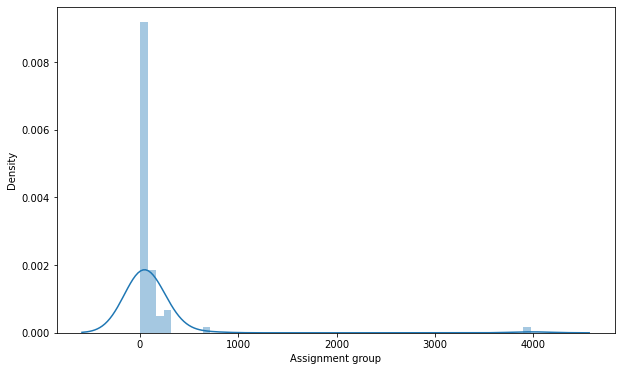

In [15]:
plt.figure(figsize=(10,6))
sns.distplot(ticket_data['Assignment group'].value_counts())

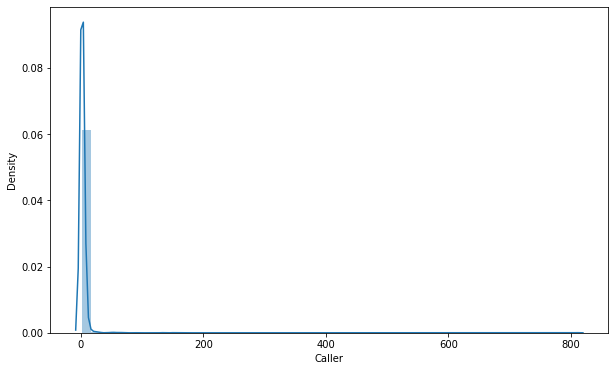

In [16]:
plt.figure(figsize=(10,6))
sns.distplot(ticket_data['Caller'].value_counts())

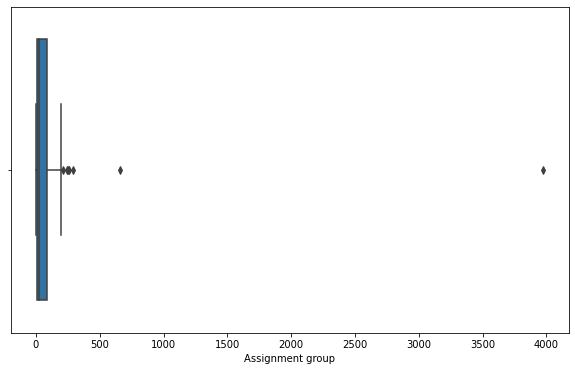

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(ticket_data['Assignment group'].value_counts())

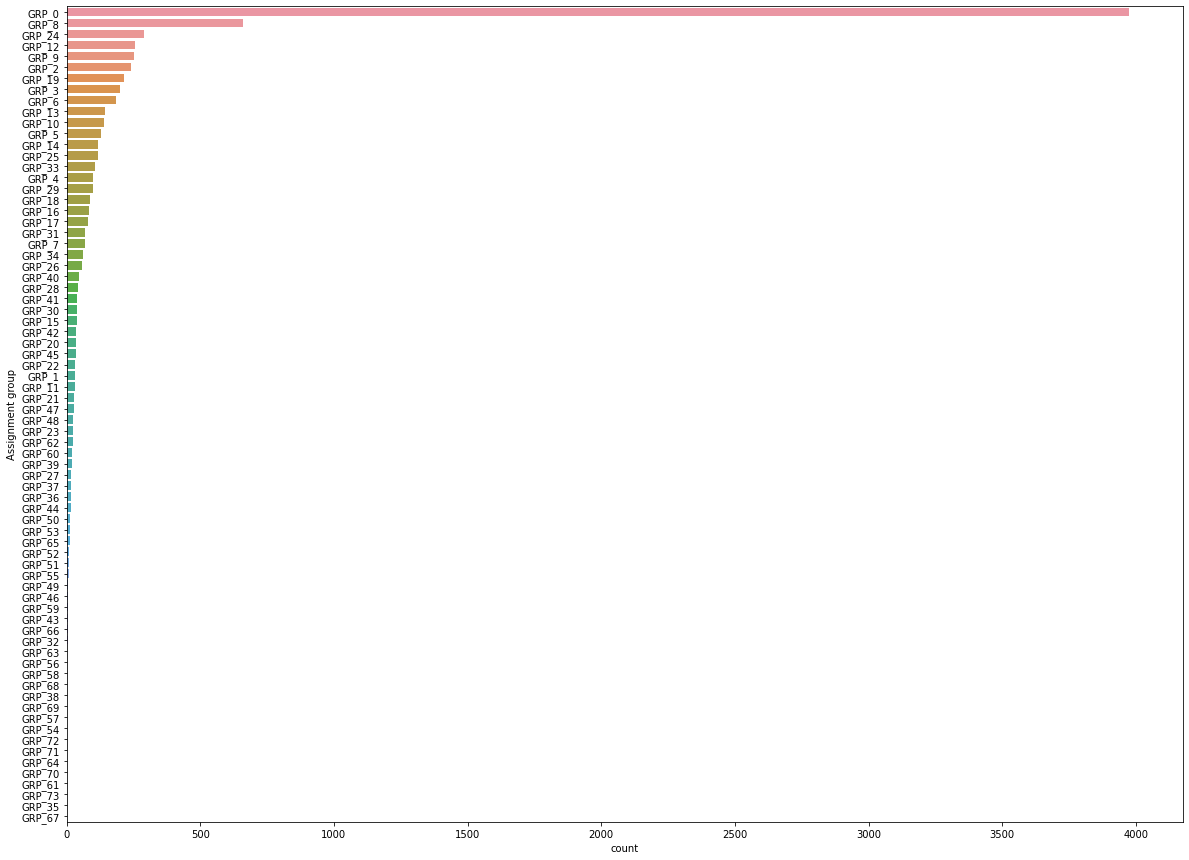

In [18]:
plt.figure(figsize=(20,15))
sns.countplot(y="Assignment group", data=ticket_data, order=ticket_data['Assignment group'].value_counts().index )

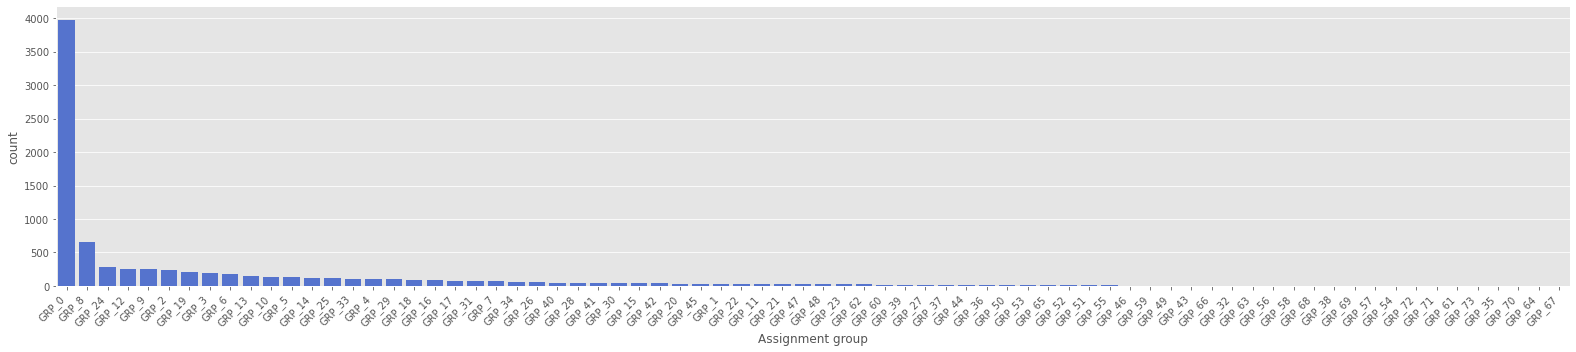

In [19]:
plt.style.use('ggplot')
%matplotlib inline

descending_order = ticket_data['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=ticket_data, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
ticket_data.isnull().values.any()

True

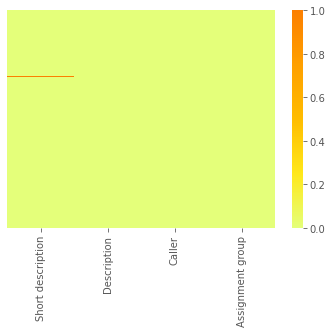

In [21]:
sns.heatmap(ticket_data.isnull(), yticklabels=False, cmap="Wistia")

In [22]:
ticket_data['Description'].fillna(value=' ', inplace=True)
ticket_data['Short description'].fillna(value=' ', inplace=True)
ticket_data.isnull().values.any()

False

## TODO: Somewhere in the initial EDA, We must remove the records where both Short desc and Desc are blank. While there is no such record in the data, we should still have this

In [23]:
summary_data=ticket_data.pivot_table(columns = "Assignment group",aggfunc='count')
summary_data

Assignment group,GRP_0,GRP_1,GRP_10,GRP_11,GRP_12,GRP_13,GRP_14,GRP_15,GRP_16,GRP_17,GRP_18,GRP_19,GRP_2,GRP_20,GRP_21,GRP_22,GRP_23,GRP_24,GRP_25,GRP_26,GRP_27,GRP_28,GRP_29,GRP_3,GRP_30,GRP_31,GRP_32,GRP_33,GRP_34,GRP_35,GRP_36,GRP_37,GRP_38,GRP_39,GRP_4,GRP_40,GRP_41,GRP_42,GRP_43,GRP_44,GRP_45,GRP_46,GRP_47,GRP_48,GRP_49,GRP_5,GRP_50,GRP_51,GRP_52,GRP_53,GRP_54,GRP_55,GRP_56,GRP_57,GRP_58,GRP_59,GRP_6,GRP_60,GRP_61,GRP_62,GRP_63,GRP_64,GRP_65,GRP_66,GRP_67,GRP_68,GRP_69,GRP_7,GRP_70,GRP_71,GRP_72,GRP_73,GRP_8,GRP_9
Caller,3976,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252
Description,3976,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252
Short description,3976,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252


In [24]:
ticket_data['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [25]:
len(ticket_data['Assignment group'].unique())

74

In [26]:
df_assg = ticket_data['Assignment group'].value_counts().reset_index()
df_assg['percentage'] = (df_assg['Assignment group']/df_assg['Assignment group'].sum())*100
df_assg.head()

,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706


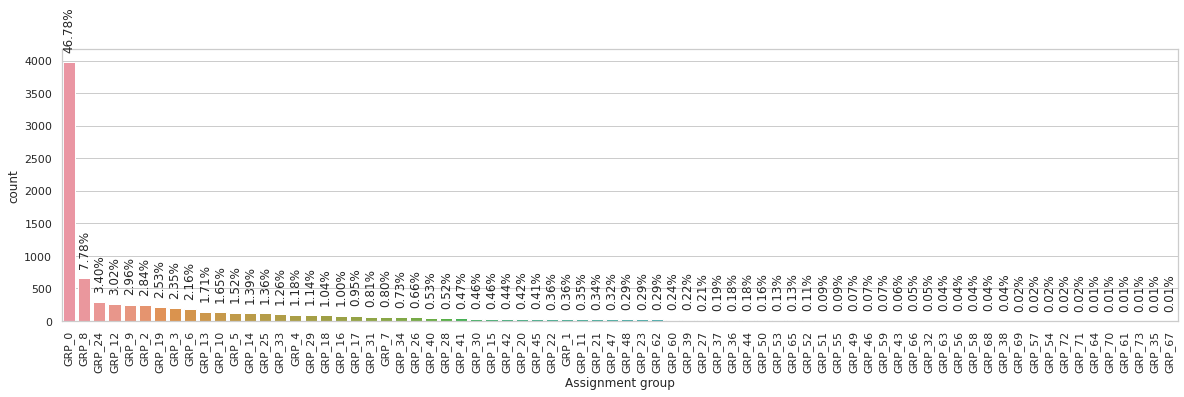

In [27]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=ticket_data, order=ticket_data["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(str(format(p.get_height()/len(ticket_data.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

#### Top 20 Assignment groups with highest number of tickets

In [28]:
df_top_assg = ticket_data['Assignment group'].value_counts().nlargest(20).reset_index()
df_top_assg

,index,Assignment group
0,GRP_0,3976
1,GRP_8,661
2,GRP_24,289
3,GRP_12,257
4,GRP_9,252
5,GRP_2,241
6,GRP_19,215
7,GRP_3,200
8,GRP_6,184
9,GRP_13,145


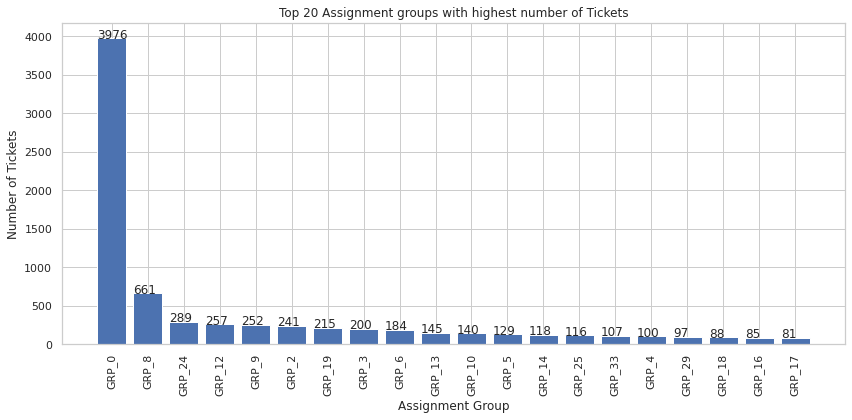

In [29]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_top_assg['index'],df_top_assg['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

#### Visualize the percentage of incidents per assignment group

In [30]:
df_bottom_assg = ticket_data['Assignment group'].value_counts().nsmallest(20).reset_index()
df_bottom_assg

,index,Assignment group
0,GRP_64,1
1,GRP_70,1
2,GRP_61,1
3,GRP_73,1
4,GRP_35,1
5,GRP_67,1
6,GRP_69,2
7,GRP_57,2
8,GRP_54,2
9,GRP_72,2


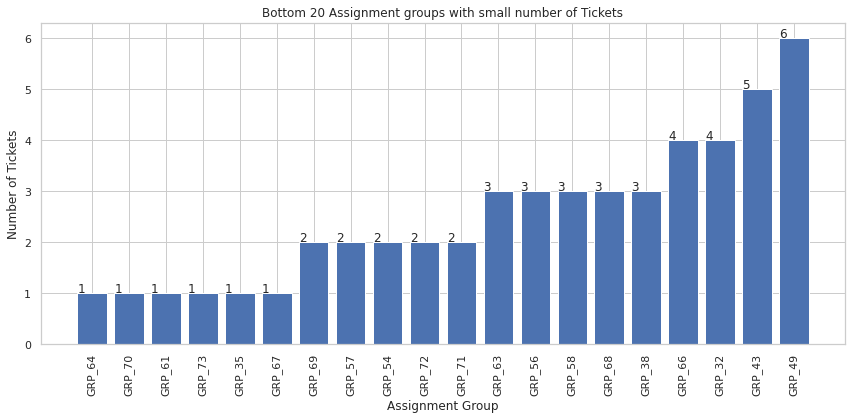

In [31]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_bottom_assg['index'],df_bottom_assg['Assignment group'])
plt.title('Bottom 20 Assignment groups with small number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

In [32]:
df_tickets = pd.DataFrame(columns=['Description','Ticket Count'])
one_ticket = {'Description':'1','Ticket Count':len(df_assg[df_assg['Assignment group'] < 2])}
_2_5_ticket = {'Description':'2-5',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 1)& (df_assg['Assignment group'] < 6) ])}
_10_ticket = {'Description':' 6-10',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 5)& (df_assg['Assignment group'] < 11)])}
_10_20_ticket = {'Description':' 11-20',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 10)& (df_assg['Assignment group'] < 21)])}
_20_50_ticket = {'Description':' 21-50',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 20)& (df_assg['Assignment group'] < 51)])}
_51_100_ticket = {'Description':' 51-100',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 50)& (df_assg['Assignment group'] < 101)])}
_100_ticket = {'Description':' >100',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 100)])}
#append row to the dataframe
df_tickets = df_tickets.append([one_ticket,_2_5_ticket,_10_ticket,
                          _10_20_ticket,_20_50_ticket,_51_100_ticket,_100_ticket], ignore_index=True)

df_tickets

,Description,Ticket Count
0,1,6
1,2-5,13
2,6-10,6
3,11-20,9
4,21-50,16
5,51-100,9
6,>100,15


(-1.1019890551483629,
 1.1224353061977401,
 -1.1079626168723997,
 1.1159579389457492)

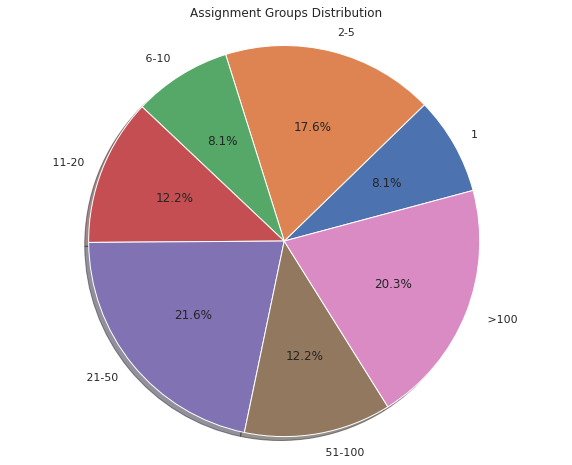

In [33]:
plt.figure(figsize=(10, 8))
plt.pie(df_tickets['Ticket Count'],labels=df_tickets['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution')
plt.axis('equal')

In [34]:
ticket_data[ticket_data['Short description'].isnull()]

,Short description,Description,Caller,Assignment group


In [35]:
ticket_data[ticket_data['Description'].isnull()]

,Short description,Description,Caller,Assignment group


## Begin Data Cleaning

### Replacing NaN

In [36]:
#Replace NaN values in Short Description and Description columns
ticket_data['Short description'] = ticket_data['Short description'].replace(np.nan, '', regex=True)
ticket_data['Description'] = ticket_data['Description'].replace(np.nan, '', regex=True)

### Decoding the data

In [37]:
#Lets encode the string, to make it easier to be passed to language detection api.
def fn_decode_to_ascii(df):
  text = df.encode().decode('utf-8').encode('ascii', 'ignore')
  return text.decode("utf-8") 

### Prepping potential boilerplate text for removal

In [38]:
#As different lines are of different length. We need to pad the our sequences using the max length
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

## Cleaning the encoding

In [39]:
ticket_data['Description'] = ticket_data['Description'].apply(fn_decode_to_ascii)
ticket_data['Short description'] = ticket_data['Short description'].apply(fn_decode_to_ascii)
ftfy_ShortDescription = []
for Short_Description in ticket_data['Short description']:
  ftfy_ShortDescription.append(fix_text(Short_Description))
ticket_data['Short description']= ftfy_ShortDescription
ftfy_Description = []
for Description in ticket_data['Description']:
  ftfy_Description.append(fix_text(Description))
ticket_data['Description']= ftfy_Description

In [40]:
svc_domains = ['.com','.com.au','.com.ar','.co.kr','.co.in','.co.jp','.at','.de','.ru','.ch','.fr','.es','.ae']
svc_urls = ['http://translate.google' + domain for domain in svc_domains]
import time

In [41]:
test_data = ticket_data.copy()
test_data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [42]:
'''test_data = ticket_data.copy()
total_size = len (test_data)
# List of column data to consider for translation
trans_cols = ['Short description','Description']
# Add a new column to store the detected language
test_data.insert(loc=2, column='lang_short_desc', value=np.nan, allow_duplicates=True)
test_data.insert(loc=2, column='lang_desc', value=np.nan, allow_duplicates=True)
start = 0
stop = 100
i = 0
while (stop < total_size):
  gs = Goslate(service_urls=svc_urls)
  for idx in range(100):
    print(idx)
    lang = gs.detect(' '.join(test_data.loc[idx + start, trans_cols].tolist()))
    row_iter = gs.translate(test_data.loc[idx + start, trans_cols].tolist(), 
                            target_language='en', 
                            source_language='auto')
    test_data.loc[idx + start, trans_cols] = list(row_iter)
    test_data.lang_desc = lang

  start = start + 100
  stop = total_size if total_size - stop < 100 else stop + 100
  if start > total_size:
    break
  print("iter", start/100)
  time.sleep(1)'''

'test_data = ticket_data.copy()\ntotal_size = len (test_data)\n# List of column data to consider for translation\ntrans_cols = [\'Short description\',\'Description\']\n# Add a new column to store the detected language\ntest_data.insert(loc=2, column=\'lang_short_desc\', value=np.nan, allow_duplicates=True)\ntest_data.insert(loc=2, column=\'lang_desc\', value=np.nan, allow_duplicates=True)\nstart = 0\nstop = 100\ni = 0\nwhile (stop < total_size):\n  gs = Goslate(service_urls=svc_urls)\n  for idx in range(100):\n    print(idx)\n    lang = gs.detect(\' \'.join(test_data.loc[idx + start, trans_cols].tolist()))\n    row_iter = gs.translate(test_data.loc[idx + start, trans_cols].tolist(), \n                            target_language=\'en\', \n                            source_language=\'auto\')\n    test_data.loc[idx + start, trans_cols] = list(row_iter)\n    test_data.lang_desc = lang\n\n  start = start + 100\n  stop = total_size if total_size - stop < 100 else stop + 100\n  if start > to

### Defining Translation functions

In [43]:
from googletrans import Translator
translator = Translator(service_urls=[
      'translate.google.com'
    ])

##Translating word by word using Google and MyMemory
def translate_word_by_word(sentence):
  words = sentence.split(" ")
  new_words = []
  for word in words:
    lang = detect(word)
    translator = Translator(provider='translate.google.com', to_lang="en", from_lang = lang, secret_access_key=None)
    new_word = translator.translate(word)
    new_words.append(new_word)
  return " ".join(new_words)

def get_lang(para):
  para = para.strip()
  if para == "":
    return "en"
  
  lang = "en"
  try:
    lang = detect(para)
  except:
    attempts = 0
    lang = "en"
    while attempts < 3:
      try:
        lang = translator.detect(para).text
        break
      except:
        lang = "en"
        attempts = attempts + 1
        time.sleep(2)
  if lang == "":
    lang = "en"
  return lang 

## translating using googletranslate
def translate_sentence(para, lang, num):
  para = para.strip()
  if para == "":
    return para
  attempts = 0
  while attempts < 3:
    try:
      if lang != "en":
        translated_text = translator.translate(para, src = lang, dest = "en").text
        return translated_text
      else:
        return (para)
    except: 
      time.sleep(1) #adding a wait
      attempts = attempts + 1

  print("failed", " ", lang, " ", num)
  return para

def translate_sentence_no_wait(para, lang, num):
  para = para.strip()
  if para == "":
    return para
  try:
    if lang != "en":
      translated_text = translator.translate(para, src = lang, dest = "en").text
      return translated_text
    else:
      return (para)
  except: 
    print("failed", " ", lang, " ", num)
  return para

In [44]:
if os.path.exists(folder_path + "/" + "translated_data.pickle"):
  ticket_data = get_pickle_data("translated_data.pickle")
  print("picking from pickle")
else:
  ticket_data["lang_short_desc"] = ticket_data["Short description"].apply(get_lang)
  ticket_data["lang_desc"] = ticket_data["Description"].apply(get_lang)
  ticket_data["SD_translated_lang"] = ticket_data["lang_short_desc"]
  ticket_data["D_translated_lang"] = ticket_data["lang_desc"]
  ticket_data["SD_translated"] = ticket_data["Short description"]
  ticket_data["D_translated"] = ticket_data["Description"]
  j = 0
  counter = len(ticket_data)
  while ((np.sum(ticket_data["SD_translated_lang"] != "en") != 0) & (np.sum(ticket_data["D_translated_lang"] != "en") != 0)):
    for i in range(counter):
      if ticket_data["SD_translated_lang"][i] != "en":
        ticket_data["SD_translated"][i] = translate_sentence(ticket_data["SD_translated"][i], ticket_data["SD_translated_lang"][i],i)
        if ticket_data["SD_translated"][i] != ticket_data["Short description"][i]:
          ticket_data["SD_translated_lang"][i] = "en"
      if ticket_data["D_translated_lang"][i] != "en":
        ticket_data["D_translated"][i] = translate_sentence(ticket_data["D_translated"][i], ticket_data["D_translated_lang"][i],i)
        if ticket_data["D_translated"][i] != ticket_data["Description"][i]:
          ticket_data["D_translated_lang"][i] = "en"
    j = j + 1
    time.sleep(5)
    print("iteration", j, " SD remaining: ", np.sum(ticket_data["SD_translated_lang"] != "en"), "D remaining: ", np.sum(ticket_data["D_translated_lang"] != "en"))
    if j == 3:
      break

picking from pickle


In [45]:
np.sum(ticket_data["D_translated_lang"] != "en")

572

In [46]:
pickle_dump(ticket_data, "translated_data.pickle")

### Function for cleaning data

In [47]:
max_features = 10000
MAX_LENGTH = 250

def clean_text(text):
    if text != "":          
      '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
      and remove words containing numbers.'''
      '''text=text.replace(('first name: ').lower(),'firstname')
      text=text.replace(('last name: ').lower(),'lastname')
      text=text.replace(('received from:').lower(),'')
      text=text.replace('email:','')
      text=text.replace('email address:','') 
      index1=text.find('from:')
      index2=text.find('\nsddubject:')
      text=text.replace(text[index1:index2],'')
      index3=text.find('[cid:image')
      index4=text.find(']')
      text=text.replace(text[index3:index4],'')
      text=text.replace('subject:','')
      text=text.replace('received from:','')
      text=text.replace('this message was sent from an unmonitored email address', '')
      text=text.replace('please do not reply to this message', '')
      text=text.replace('monitoring_tool@company.com','MonitoringTool')
      text=text.replace('select the following link to view the disclaimer in an alternate language','')
      text=text.replace('description problem', '') 
      text=text.replace('steps taken far', '')
      text=text.replace('customer job title', '')
      text=text.replace('sales engineer contact', '')
      text=text.replace('description of problem:', '')
      text=text.replace('steps taken so far', '')
      text=text.replace('please do the needful', '')
      text=text.replace('please note that ', '')
      text=text.replace('please find below', '')
      text=text.replace('date and time', '')
      text=text.replace('kindly refer mail', '')
      text=text.replace('name:', '')
      text=text.replace('language:', '')
      text=text.replace('customer number:', '')
      text=text.replace('telephone:', '')
      text=text.replace('summary:', '')
      text=text.replace('sincerely', '')
      text=text.replace('company inc', '')
      text=text.replace('importance:', '')
      text=text.replace('gmail.com', '')
      text=text.replace('company.com', '')
      text=text.replace('microsoftonline.com', '')
      text=text.replace('company.onmicrosoft.com', '')
      text=text.replace('hello', '')
      text=text.replace('hallo', '')
      text=text.replace('hi it team', '')
      text=text.replace('hi team', '')
      text=text.replace('hi', '')
      text=text.replace('best', '')
      text=text.replace('kind', '')
      text=text.replace('regards', '')
      text=text.replace('good morning', '')
      text=text.replace('please', '')
      text=text.replace('regards', '')'''
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'<br />', ' ', text)    
      text = re.sub(r'\S+@\S+', '', text)
      text = re.sub(r'\d+','' ,text)
      text = re.sub(r'#','', text)
      text = re.sub(r'&;?', 'and',text)
      text = re.sub(r'\&\w*;', '', text)
      text = re.sub(r'https?:\/\/.*\/\w*', '', text)
      custom_punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~'
      text = re.sub(r'\w*\d\w*', '', text)
      text = re.sub(r'\[.*?\]', '', text)
      text = re.sub(r'https?://\S+|www\.\S+', '', text)
      text = re.sub(r'<.*?>+', '', text)
      text= ''.join(c for c in text if c <= '\uFFFF') 
      text = text.strip()      
      text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
      text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
      text = re.sub(r'\r\n', '', text)
      text = re.sub(r'\n', '', text)
      text = re.sub(r'\S+@\S+', '', text)

      text = text.lower()
    return text

### Data cleaning, stop word removal and lemmatization

In [48]:
#ticket_data['lang_desc'] = ticket_data['Description'].apply(detect_lang)
#ticket_data['lang_short_desc'] = ticket_data['Short description'].apply(detect_lang)
#ticket_data['Description'] = ticket_data.apply(lambda x: fn_translate(x['Description']), axis=1)
#ticket_data['Short description'] = ticket_data.apply(lambda x: fn_translate(x['Short description']), axis=1)
ticket_data["Description"] = ticket_data["Description"].apply(clean_text)
ticket_data["Short description"] = ticket_data["Short description"].apply(clean_text)
print(len(ticket_data))

8500


In [49]:
ticket_pivot = ticket_data.pivot_table(aggfunc="count",columns ="Assignment group", values="Caller")
ticket_nums = np.array(ticket_pivot)
ticket_cols = ticket_pivot.columns
ticket_pivot_df = pd.DataFrame(data = ticket_nums, columns = ticket_cols, index = ["Number of tickets"])
ticket_pivot_df = ticket_pivot_df.transpose()
ticket_pivot_df.reset_index(inplace=True)

In [50]:
def filter_group_augment (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>20) & (ticket_pivot_df["Number of tickets"]<1000)]["Assignment group"]):
    return True
  else:
    return False

def filter_group_large (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>=1000)]["Assignment group"]):
    return True
  else:
    return False

def filter_group_small (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]<=20)]["Assignment group"]):
    return True
  else:
    return False

def filter_group_AI (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>20)]["Assignment group"]):
    return True
  else:
    return False

In [51]:
data_to_be_augmented = ticket_data[ticket_data["Assignment group"].apply(filter_group_augment)]
data_large_tickets = ticket_data[ticket_data["Assignment group"].apply(filter_group_large)]
data_small_tickets = ticket_data[ticket_data["Assignment group"].apply(filter_group_small)]

In [52]:
data_to_be_augmented.shape

(4298, 10)

In [53]:
data_large_tickets.shape

(3976, 10)

In [54]:
data_small_tickets.shape

(226, 10)

In [55]:
def replace_with_synonym(sentence):
  if sentence != "":
    synonym = ""
    words = sentence.split(" ")    
    repl_num = 0
    syn_idx = 0
    for i in range(5):
      if len(words) > 1:
        repl_num = rnd.randint(0,len(words)-1)
      elif len(words) == 1:
        repl_num = 0
      else:
        return sentence
      syns = wordnet.synsets(words[repl_num])
      if len(syns) > 1:
        syn_idx = rnd.randint(0,len(syns)-1)
        synonym = syns[syn_idx].lemmas()[0].name()
      elif len(syns) == 1:
        syn_idx = 0
        synonym = syns[syn_idx].lemmas()[0].name()
      else:
        synonym = ""
      if synonym != "":
        sentence = sentence.replace(words[repl_num], synonym)
  return sentence

def drop_words(sentence):
  if sentence != "":
    words = sentence.split(" ")    
    repl_num = 0
    for i in range(5):
      if len(words) > 1:
        repl_num = rnd.randint(0,len(words)-1)
      elif len(words) == 1:
        repl_num = 0
      else:
        return sentence
      words[repl_num] = ""
    sentence = " ".join(words)
  return sentence

def scatter_sentences(para):
  sentences = para.split(".")
  i=0
  for sentence in sentences:
      sentences[i] = sentence.strip()
      i = i+1
  total = len(sentences)
  i = 0
  new_order = []
  while (len(new_order) < total):
      num = rnd.randint(0,total-1)
      if num not in new_order:
          new_order.append(num)
          i = i + 1
  new_sentences = [sentences[i] for i in new_order]
  total_sentences = len(new_sentences)
  return_para = ""
  for i in range(total_sentences):
    if not new_sentences[i] == "":
      if return_para == "":
        return_para = new_sentences[i]
      else:
        return_para = return_para + "." + new_sentences[i]
  return return_para

In [56]:
ticket_pivot_df_augment = ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>20) & (ticket_pivot_df["Number of tickets"]<1000)]

In [57]:
ticket_pivot_df_augment = ticket_pivot_df_augment.reset_index()
ticket_pivot_df_augment.drop(["index"], axis = 1, inplace = True)

In [58]:
def augment_data(df):
  total_grps = len(ticket_pivot_df_augment)
  ticket_data_updated = df.copy()
  list_to_add = []
  list_df = []
  col_names = ticket_data_updated.columns.values.tolist()
  for i in range(total_grps):
    grpname = ticket_pivot_df_augment["Assignment group"][i]
    group_df = ticket_data_updated[ticket_data_updated["Assignment group"]==grpname]
    list_df = group_df.values.tolist()
    group_df = None
    records_added = ticket_pivot_df_augment["Number of tickets"][i]
    while records_added < 500:
      list_df = list_df + list_df
      records_added = records_added + records_added
    list_to_add = list_to_add + list_df
    list_df = []
    gc.collect()
  #ticket_data_updated.info()
  #ticket_data_updated = pd.DataFrame(data = final_df, columns= col_names)
  df_to_add = pd.DataFrame(data = list_to_add, columns = ticket_data.columns)
  df_to_add["Description"] = df_to_add["Description"].apply(replace_with_synonym)
  df_to_add["Short description"] = df_to_add["Short description"].apply(replace_with_synonym)
  ticket_data_updated = pd.concat([ticket_data_updated, df_to_add],axis = 0)
  print("first", gc.collect())

  '''df_to_add = pd.DataFrame(data = list_to_add, columns = ticket_data.columns)
  df_to_add["Description"] = df_to_add["Description"].apply(scatter_sentences)
  df_to_add["Short description"] = df_to_add["Short description"].apply(scatter_sentences)
  ticket_data_updated = pd.concat([ticket_data_updated, df_to_add],axis = 0) 
  print("second:", gc.collect())

  df_to_add = pd.DataFrame(data = list_to_add, columns = ticket_data.columns)
  df_to_add["Description"] = df_to_add["Description"].apply(drop_words)
  df_to_add["Short description"] = df_to_add["Short description"].apply(drop_words)
  ticket_data_updated = pd.concat([ticket_data_updated, df_to_add],axis = 0)
  print("third", gc.collect())'''
  return ticket_data_updated

### Augment the data here
augmented_data = ""
if os.path.exists(folder_path + "/" + "augmented_data.pickle"):
  augmented_data = get_pickle_data("augmented_data.pickle")
  print("picking from pickle")
else:
  augmented_data = augment_data(data_to_be_augmented)
  print("augmented")
  augmented_data = pd.concat([augmented_data,data_large_tickets], axis = 0)
  augmented_data = pd.concat([augmented_data,data_small_tickets], axis = 0)

augmented_data = augmented_data.reset_index()
augmented_data.drop(["index"], axis = 1, inplace = True)

pickle_dump(augmented_data, "augmented_data.pickle")
augmented_data.head()

picking from pickle


,Short description,Description,Caller,Assignment group,lang_short_desc,lang_desc,SD_translated_lang,D_translated_lang,SD_translated,D_translated
0,event criticalhostnamecompanycom the value of ...,event criticalhostnamecompanycom the value of ...,jyoqwxhz clhxsoqy,GRP_1,en,en,en,en,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...
1,when undocking pc screen will not come back,when undocking pc screen will not come back,sigfdwcj reofwzlm,GRP_3,en,en,en,en,"when undocking pc , screen will not come back","when undocking pc , screen will not come back"
2,duplication of network address,received from gentles i have two devices that ...,kxsceyzo naokumlb,GRP_4,en,en,en,en,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...
3,please reroute jobs on printer to printer issu...,received from hi the printer printer is not wo...,yisohglr uvteflgb,GRP_5,en,en,en,en,please reroute jobs on printer01 to printer02 ...,\n\nreceived from: yisohglr.uvteflgb@gmail.com...
4,job job failed in jobscheduler at,received from job job failed in jobscheduler at,bpctwhsn kzqsbmtp,GRP_6,en,en,en,en,job Job_1424 failed in job_scheduler at: 10/31...,received from: monitoring_tool@company.com\n\n...


In [59]:
augmented_data.shape

(37269, 10)

In [60]:
deep_learning_df = " "
if os.path.exists(folder_path + "/deep_learning_df.pickle"):
  deep_learning_df = get_pickle_data("deep_learning_df.pickle")
else:
  deep_learning_df = augmented_data[augmented_data["Assignment group"].apply(filter_group_AI)]
deep_learning_df = deep_learning_df.reset_index()
deep_learning_df.drop(["index"], axis = 1, inplace = True)
deep_learning_df["Description_New"] = deep_learning_df["Short description"] + deep_learning_df["Description"]
pickle_dump(deep_learning_df, "deep_learning_df.pickle")

In [61]:
deep_learning_df.shape

(37043, 11)

In [62]:
augmented_data.shape

(37269, 10)

In [63]:
stop = stopwords.words('english')
augmented_data["Description"] = augmented_data["Description"].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
augmented_data["Short description"] = augmented_data["Short description"].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
augmented_data['Short description']= augmented_data['Short description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))
augmented_data['Description']= augmented_data['Description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

pickle_dump(augmented_data, "lemmatized_data.pickle")
augmented_data.head()

,Short description,Description,Caller,Assignment group,lang_short_desc,lang_desc,SD_translated_lang,D_translated_lang,SD_translated,D_translated
0,event criticalhostnamecompanycom value mountpo...,event criticalhostnamecompanycom value mountpo...,jyoqwxhz clhxsoqy,GRP_1,en,en,en,en,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...
1,undocking pc screen come back,undocking pc screen come back,sigfdwcj reofwzlm,GRP_3,en,en,en,en,"when undocking pc , screen will not come back","when undocking pc , screen will not come back"
2,duplication network address,received gentles two device trying share ip ad...,kxsceyzo naokumlb,GRP_4,en,en,en,en,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...
3,please reroute job printer printer issue need ...,received hi printer printer working need part ...,yisohglr uvteflgb,GRP_5,en,en,en,en,please reroute jobs on printer01 to printer02 ...,\n\nreceived from: yisohglr.uvteflgb@gmail.com...
4,job job failed jobscheduler,received job job failed jobscheduler,bpctwhsn kzqsbmtp,GRP_6,en,en,en,en,job Job_1424 failed in job_scheduler at: 10/31...,received from: monitoring_tool@company.com\n\n...


In [64]:
ticket_data["lang_desc"].value_counts()

en    7075
de     396
af     262
it     150
fr     107
no      71
ca      66
es      62
sv      59
nl      55
pl      31
da      30
pt      21
sl      19
cy      14
tl      14
ro      14
sq       9
et       7
fi       7
hr       7
so       5
id       5
lv       4
lt       3
cs       2
sk       2
vi       1
tr       1
sw       1
Name: lang_desc, dtype: int64

In [65]:
ticket_data["lang_short_desc"].value_counts()

en    6032
af     508
de     404
it     279
fr     262
no     161
nl     145
ca     120
es     104
da      90
sv      83
pl      50
ro      38
pt      33
cy      26
sl      25
tl      25
sq      16
id      14
et      14
sk      14
fi      13
lv       9
cs       8
lt       8
hr       7
so       5
vi       4
tr       2
sw       1
Name: lang_short_desc, dtype: int64

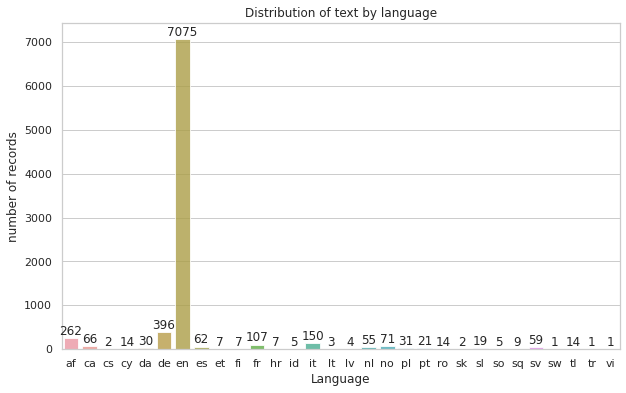

In [66]:
x = ticket_data["lang_desc"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

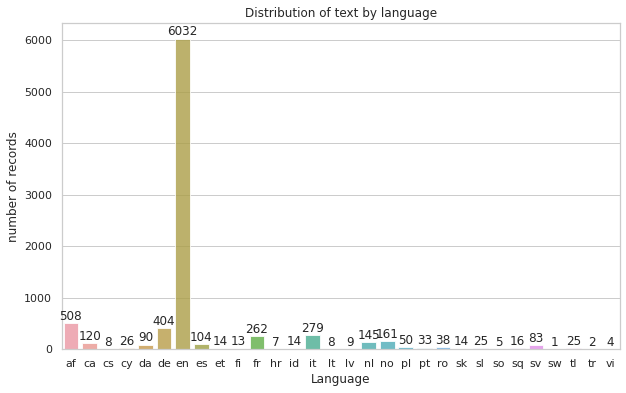

In [67]:
x = ticket_data["lang_short_desc"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

## Feature Engineering

In [68]:
augmented_data['Description_New'] = augmented_data['Short description'] + augmented_data['Description']
augmented_data['num_wds'] = augmented_data['Description_New'].apply(lambda x: len(x.split()))
augmented_data['num_wds'].mean()

24.940298907939574

In [69]:
print(augmented_data['num_wds'].max())
print(augmented_data['num_wds'].min())

961
0


In [70]:
len(augmented_data[augmented_data['num_wds']==0])

828

In [71]:
augmented_data['uniq_wds'] = augmented_data['Description_New'].str.split().apply(lambda x: len(set(x)))
augmented_data['uniq_wds'].head()

0     7
1     6
2    30
3    39
4     4
Name: uniq_wds, dtype: int64

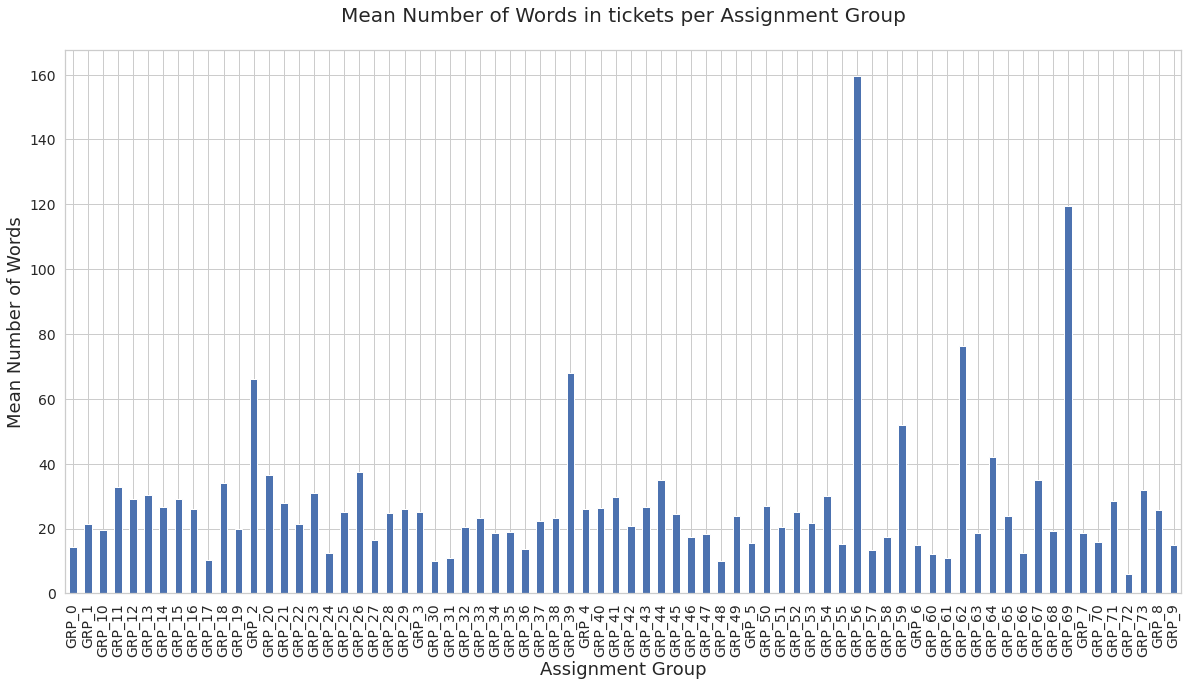

In [72]:
assign_grps = augmented_data.groupby('Assignment group')
ax=assign_grps['num_wds'].aggregate(np.mean).plot(kind='bar', fontsize=14, figsize=(20,10))
ax.set_title('Mean Number of Words in tickets per Assignment Group\n', fontsize=20)
ax.set_ylabel('Mean Number of Words', fontsize=18)
ax.set_xlabel('Assignment Group', fontsize=18);

Text(0.5, 0, 'Assignment Group')

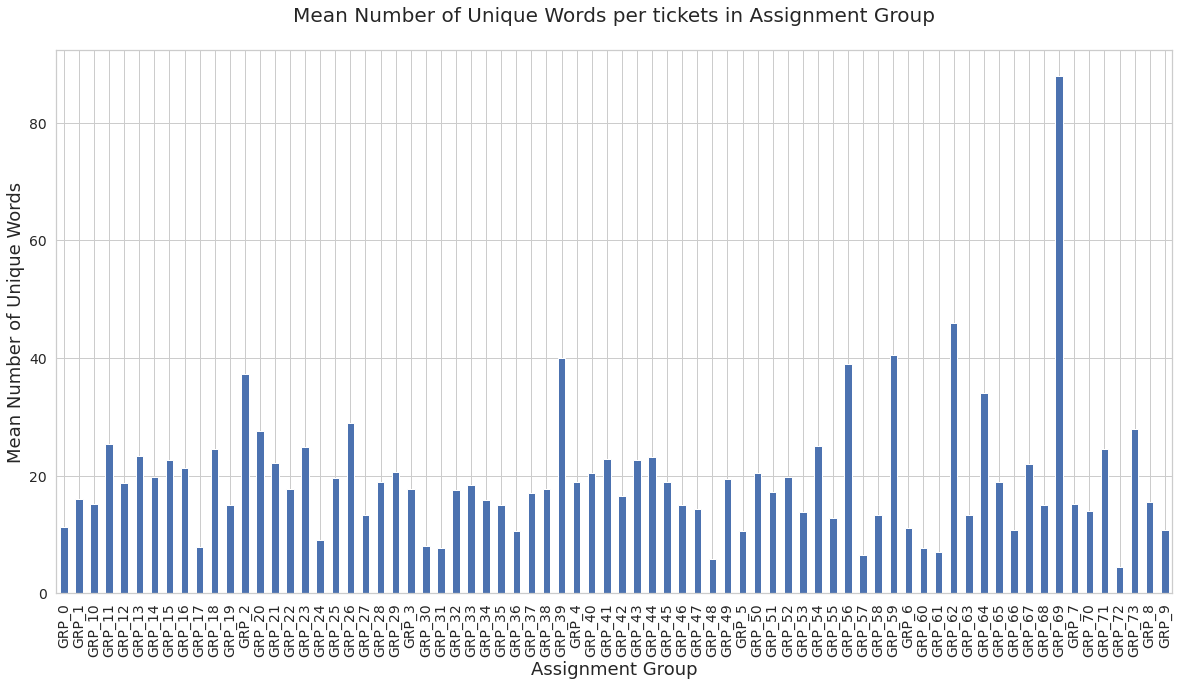

In [73]:
ax=assign_grps['uniq_wds'].aggregate(np.mean).plot(kind='bar', fontsize=14, figsize=(20,10))
ax.set_title('Mean Number of Unique Words per tickets in Assignment Group\n', fontsize=20)
ax.set_ylabel('Mean Number of Unique Words', fontsize=18)
ax.set_xlabel('Assignment Group', fontsize=18)

In [74]:
word_counts = Counter()
for i, row in augmented_data.iterrows():
    word_counts.update(row['Description_New'].split())
    
word_counts.most_common(20)

[('please', 9698),
 ('job', 7900),
 ('erp', 6736),
 ('user', 5740),
 ('access', 5108),
 ('error', 5060),
 ('password', 4517),
 ('issue', 4264),
 ('e', 4165),
 ('company', 4124),
 ('failed', 3960),
 ('need', 3934),
 ('jobscheduler', 3778),
 ('crm', 3734),
 ('sid', 3520),
 ('system', 3444),
 ('yesnona', 3313),
 ('email', 3269),
 ('event', 3195),
 ('account', 3164)]

In [75]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
augmented_data['token_desc'] = augmented_data['Description_New'].apply(lambda x: tokenizer.tokenize(x))
augmented_data['token_desc'].head()

0    [event, criticalhostnamecompanycom, value, mou...
1    [undocking, pc, screen, come, backundocking, p...
2    [duplication, network, addressreceived, gentle...
3    [please, reroute, job, printer, printer, issue...
4    [job, job, failed, jobschedulerreceived, job, ...
Name: token_desc, dtype: object

In [76]:
augmented_data.head()

,Short description,Description,Caller,Assignment group,lang_short_desc,lang_desc,SD_translated_lang,D_translated_lang,SD_translated,D_translated,Description_New,num_wds,uniq_wds,token_desc
0,event criticalhostnamecompanycom value mountpo...,event criticalhostnamecompanycom value mountpo...,jyoqwxhz clhxsoqy,GRP_1,en,en,en,en,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,event criticalhostnamecompanycom value mountpo...,11,7,"[event, criticalhostnamecompanycom, value, mou..."
1,undocking pc screen come back,undocking pc screen come back,sigfdwcj reofwzlm,GRP_3,en,en,en,en,"when undocking pc , screen will not come back","when undocking pc , screen will not come back",undocking pc screen come backundocking pc scre...,9,6,"[undocking, pc, screen, come, backundocking, p..."
2,duplication network address,received gentles two device trying share ip ad...,kxsceyzo naokumlb,GRP_4,en,en,en,en,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...,duplication network addressreceived gentles tw...,41,30,"[duplication, network, addressreceived, gentle..."
3,please reroute job printer printer issue need ...,received hi printer printer working need part ...,yisohglr uvteflgb,GRP_5,en,en,en,en,please reroute jobs on printer01 to printer02 ...,\n\nreceived from: yisohglr.uvteflgb@gmail.com...,please reroute job printer printer issue need ...,57,39,"[please, reroute, job, printer, printer, issue..."
4,job job failed jobscheduler,received job job failed jobscheduler,bpctwhsn kzqsbmtp,GRP_6,en,en,en,en,job Job_1424 failed in job_scheduler at: 10/31...,received from: monitoring_tool@company.com\n\n...,job job failed jobschedulerreceived job job fa...,8,4,"[job, job, failed, jobschedulerreceived, job, ..."


## Splitting the data into rule based and Machine learning based processing

In [77]:
rule_based_df = " "
machine_learning_df = " "
if os.path.exists(folder_path + "/rule_based_df.pickle"):
  rule_based_df = get_pickle_data("rule_based_df.pickle")
else:
  rule_based_df = augmented_data[augmented_data["Assignment group"].apply(filter_group_small)]

if os.path.exists(folder_path + "/machine_learning_df.pickle"):
  machine_learning_df = get_pickle_data("machine_learning_df.pickle")
else:
  machine_learning_df = augmented_data[augmented_data["Assignment group"].apply(filter_group_AI)]

In [78]:
machine_learning_df.shape

(37043, 14)

In [79]:
deep_learning_df.shape

(37043, 11)

In [80]:
rule_based_df.shape

(226, 14)

In [81]:
augmented_data.shape

(37269, 14)

In [82]:
machine_learning_df = machine_learning_df.reset_index()
machine_learning_df.drop(["index"], axis = 1, inplace = True)
rule_based_df = rule_based_df.reset_index()
rule_based_df.drop(["index"], axis = 1, inplace = True)
pickle_dump(rule_based_df, "rule_based_df.pickle")
pickle_dump(machine_learning_df, "machine_learning_df.pickle")

In [83]:
# build the vocabulary in one pass
from string import punctuation
from nltk import word_tokenize
stop_words = []
vocabulary = set()
def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]

if os.path.exists(folder_path + "/vocabulary.pickle"):
  vocabulary = get_pickle_data("vocabulary.pickle")
else:
  stop_words = stopwords.words('english') + list(punctuation)
  counter = len(machine_learning_df["token_desc"])
  for  i in range(counter):
      words = tokenize(str(machine_learning_df["Description_New"][i]))
      vocabulary.update(words)

  vocabulary = list(vocabulary) 
VOCABULARY_SIZE = len(vocabulary)
  
print(VOCABULARY_SIZE)

pickle_dump(vocabulary, "vocabulary.pickle")

40584


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize, max_features = 2000, analyzer = 'word', ngram_range=(1, 2))
inc_tfidf = tfidf.fit_transform(machine_learning_df['Description_New'])

In [85]:
inc_tfidf.shape

(37043, 2000)

In [86]:
#  create a dictionary mapping the tokens to their tfidf values
'''tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']'''

"tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))\ntfidf = pd.DataFrame(columns=['tfidf']).from_dict(\n                    dict(tfidf), orient='index')\ntfidf.columns = ['tfidf']"

Top 20 Words with highest tfidf score

In [87]:
'''tfidf.sort_values(by=['tfidf'], ascending=False).head(20)'''

"tfidf.sort_values(by=['tfidf'], ascending=False).head(20)"

Bottom 10 words with lowest tfidf score

In [88]:
''' tfidf.sort_values(by=['tfidf'], ascending=True).head(10)'''

" tfidf.sort_values(by=['tfidf'], ascending=True).head(10)"

Dimentionality Reduction

In [89]:
'''from sklearn.decomposition import TruncatedSVD

n_comp=10
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(inc_tfidf)'''

'from sklearn.decomposition import TruncatedSVD\n\nn_comp=10\nsvd = TruncatedSVD(n_components=n_comp, random_state=42)\nsvd_tfidf = svd.fit_transform(inc_tfidf)'

In [90]:
'''from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)'''

'from sklearn.manifold import TSNE\ntsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)\ntsne_tfidf = tsne_model.fit_transform(svd_tfidf)'

In [91]:
'''from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
# create count vectorizer first
cvectorizer = CountVectorizer(min_df=4, max_features=4000, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(machine_learning_df['Description_New'])

# generate topic models using Latent Dirichlet Allocation
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=20, random_state=42)
X_topics = lda_model.fit_transform(cvz)'''

"from sklearn.decomposition import LatentDirichletAllocation\nfrom sklearn.feature_extraction.text import CountVectorizer\n# create count vectorizer first\ncvectorizer = CountVectorizer(min_df=4, max_features=4000, ngram_range=(1,2))\ncvz = cvectorizer.fit_transform(machine_learning_df['Description_New'])\n\n# generate topic models using Latent Dirichlet Allocation\nlda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=20, random_state=42)\nX_topics = lda_model.fit_transform(cvz)"

In [92]:
'''n_top_words = 10
topic_summaries = []

# get topics and topic terms
topic_word = lda_model.components_ 
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))'''

"n_top_words = 10\ntopic_summaries = []\n\n# get topics and topic terms\ntopic_word = lda_model.components_ \nvocab = cvectorizer.get_feature_names()\n\nfor i, topic_dist in enumerate(topic_word):\n    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]\n    topic_summaries.append(' '.join(topic_words))\n    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))"

In [93]:
# collect the tfid matrix in numpy array
#array = inc_tfidf.todense()
array = inc_tfidf.todense()
inc_tfidf = None
# store the tf-idf array into pandas dataframe
df_inc = pd.DataFrame(array)
array = None
gc.collect()
df_inc.head(10)
df_inc.shape

(37043, 2000)

In [94]:
machine_learning_df.head()

,Short description,Description,Caller,Assignment group,lang_short_desc,lang_desc,SD_translated_lang,D_translated_lang,SD_translated,D_translated,Description_New,num_wds,uniq_wds,token_desc
0,event criticalhostnamecompanycom value mountpo...,event criticalhostnamecompanycom value mountpo...,jyoqwxhz clhxsoqy,GRP_1,en,en,en,en,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,event criticalhostnamecompanycom value mountpo...,11,7,"[event, criticalhostnamecompanycom, value, mou..."
1,undocking pc screen come back,undocking pc screen come back,sigfdwcj reofwzlm,GRP_3,en,en,en,en,"when undocking pc , screen will not come back","when undocking pc , screen will not come back",undocking pc screen come backundocking pc scre...,9,6,"[undocking, pc, screen, come, backundocking, p..."
2,duplication network address,received gentles two device trying share ip ad...,kxsceyzo naokumlb,GRP_4,en,en,en,en,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...,duplication network addressreceived gentles tw...,41,30,"[duplication, network, addressreceived, gentle..."
3,please reroute job printer printer issue need ...,received hi printer printer working need part ...,yisohglr uvteflgb,GRP_5,en,en,en,en,please reroute jobs on printer01 to printer02 ...,\n\nreceived from: yisohglr.uvteflgb@gmail.com...,please reroute job printer printer issue need ...,57,39,"[please, reroute, job, printer, printer, issue..."
4,job job failed jobscheduler,received job job failed jobscheduler,bpctwhsn kzqsbmtp,GRP_6,en,en,en,en,job Job_1424 failed in job_scheduler at: 10/31...,received from: monitoring_tool@company.com\n\n...,job job failed jobschedulerreceived job job fa...,8,4,"[job, job, failed, jobschedulerreceived, job, ..."


In [95]:
df_inc = df_inc.reset_index()
df_inc.drop(['index'],axis=1, inplace = True)

In [96]:
df_inc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552888,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
'''from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
new_features_df = machine_learning_df[["num_wds","uniq_wds"]]
new_features_scaled = min_max_scaler.fit_transform(new_features_df)
col_names = new_features_df.columns
new_features_df = pd.DataFrame(new_features_scaled, columns = col_names)'''

'from sklearn.preprocessing import MinMaxScaler\nmin_max_scaler = MinMaxScaler()\nnew_features_df = machine_learning_df[["num_wds","uniq_wds"]]\nnew_features_scaled = min_max_scaler.fit_transform(new_features_df)\ncol_names = new_features_df.columns\nnew_features_df = pd.DataFrame(new_features_scaled, columns = col_names)'

In [98]:
#new_features_df

In [99]:
#df_inc['num_wds']= new_features_df['num_wds']
#df_inc['uniq_wds']= new_features_df['uniq_wds']
df_inc['Assignment group']= machine_learning_df['Assignment group']
df_inc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,Assignment group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GRP_1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GRP_3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552888,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GRP_4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GRP_5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GRP_6


In [100]:
features = df_inc.columns.tolist()
output = 'Assignment group'
# removing the output and the id from features
features.remove(output)

In [101]:
df_inc_sample = df_inc[df_inc['Assignment group'].map(df_inc['Assignment group'].value_counts()) > 100]

In [102]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [103]:
non_eng_text=machine_learning_df.loc[machine_learning_df['Caller']=="gusyjcer lvbxfimr"]
non_eng_text

,Short description,Description,Caller,Assignment group,lang_short_desc,lang_desc,SD_translated_lang,D_translated_lang,SD_translated,D_translated,Description_New,num_wds,uniq_wds,token_desc
36638,aenderungsantrag kann nicht geloescht werden,aenderungsantrag kann nicht geloescht werden,gusyjcer lvbxfimr,GRP_0,de,de,en,en,Change request cannot be deleted.,Change request cannot be deleted.,aenderungsantrag kann nicht geloescht werdenae...,9,6,"[aenderungsantrag, kann, nicht, geloescht, wer..."
36639,net weaver business client work,net weaver business client work error m net fr...,gusyjcer lvbxfimr,GRP_0,af,af,en,en,netweaver business client does not work.,net weaver business client does not work.\nerr...,net weaver business client worknet weaver busi...,13,9,"[net, weaver, business, client, worknet, weave..."


In [104]:
Func_group = df_inc['Assignment group'].unique()
Func_group

array(['GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7', 'GRP_8',
       'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31', 'GRP_33',
       'GRP_34', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_62', 'GRP_0'], dtype=object)

In [105]:
replaceStruct = {
                "Assignment group":{
                "GRP_0":0, "GRP_1":1, "GRP_3":3, "GRP_4":4, "GRP_5":5, "GRP_6":6, "GRP_7":7,
                "GRP_8":8, "GRP_9":9, "GRP_10":10, "GRP_11":11, "GRP_12":12, "GRP_13":13, "GRP_14":14,
                "GRP_15":15, "GRP_16":16, "GRP_17":17, "GRP_18":18, "GRP_19":19, "GRP_2":2,
                "GRP_20":20, "GRP_21":21, "GRP_22":22, "GRP_23":23, "GRP_24":24, "GRP_25":25,
                "GRP_26":26, "GRP_27":27, "GRP_28":28, "GRP_29":29, "GRP_30":30, "GRP_31":31,
                "GRP_33":33, "GRP_34":34, "GRP_35":35, "GRP_36":36, "GRP_37":37, "GRP_38":38,
                "GRP_39":39, "GRP_40":40, "GRP_41":41, "GRP_42":42, "GRP_43":43, "GRP_44":44,
                "GRP_45":45, "GRP_46":46, "GRP_47":47, "GRP_48":48, "GRP_49":49, "GRP_50":50,
                "GRP_51":51, "GRP_52":52, "GRP_53":53, "GRP_54":54, "GRP_55":55, "GRP_56":56,
                "GRP_57":57, "GRP_58":58, "GRP_59":59, "GRP_60":60, "GRP_61":61, "GRP_32":32,
                "GRP_62":62, "GRP_63":63, "GRP_64":64, "GRP_65":65, "GRP_66":66, "GRP_67":67,
                "GRP_68":68, "GRP_69":69, "GRP_70":70, "GRP_71":71, "GRP_72":72, "GRP_73":73}          
                 } 

In [106]:
df_inc_target=df_inc.replace(replaceStruct)
df_inc_target.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,Assignment group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552888,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [107]:
# Split X and y into training and test set in 70:30 ratio

from sklearn.model_selection import train_test_split

X = df_inc_target.drop('Assignment group',axis=1)    
Y = df_inc_target['Assignment group']   

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10) 

x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
28991,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
20179,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187827,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
26679,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.651962,0.0
12273,0.0,0.0,0.0,0.0,0.216557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
18174,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [108]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Fit the model on train
model = LogisticRegression(solver="liblinear")
model.fit(x_train, y_train)

#predict on training data
y_predict1 = model.predict(x_train)

#predict on test data
y_predict2 = model.predict(x_test)

# Use score method to get accuracy of model
print("Model Accuracy on Training Data: {0:.4f}".format(metrics.accuracy_score(y_train, y_predict1)))
print("Model Accuracy on Test Data: {0:.4f}".format(metrics.accuracy_score(y_test, y_predict2)))

Model Accuracy on Training Data: 0.8180
Model Accuracy on Test Data: 0.7828


In [109]:
round(metrics.accuracy_score(y_train, y_predict1),2)

0.82

In [110]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_Matrix = pd.DataFrame({'Classification Model':['Logistic Regression'], 'Training Accuracy': round(metrics.accuracy_score(y_train, y_predict1),2), 'Test Accuracy': round(metrics.accuracy_score(y_test, y_predict2),2)},index={'1'})
Accuracy_Matrix = Accuracy_Matrix[['Classification Model', 'Training Accuracy','Test Accuracy']]
Accuracy_Matrix

,Classification Model,Training Accuracy,Test Accuracy
1,Logistic Regression,0.82,0.78


(2.5, -0.5)

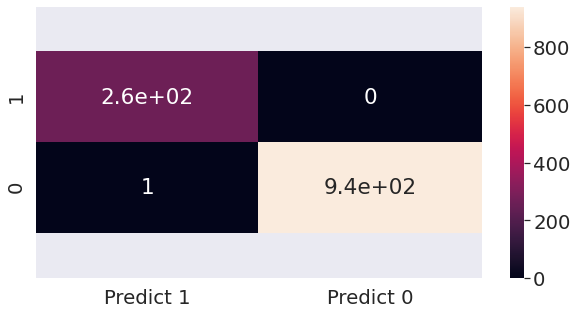

In [111]:
# Confusion Matrix for Logistic Regression

y_predict = model.predict(x_test)
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (10,5))
sns.set(font_scale=1.8)
ax=sns.heatmap(df_cm, annot=True)
bottom,top=ax.get_ylim()
ax.set_ylim(bottom +0.5, top-0.5)

In [112]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

model = LogisticRegression()

penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf = RandomizedSearchCV(model, hyperparameters, random_state=1, n_iter=10, cv=5, verbose=0, n_jobs=-1)

best_model = clf.fit(x_train, y_train)
best_model.best_params_

{'C': 3.730229437354635, 'penalty': 'l2'}

In [113]:
#Predict using the Best logistic regression model based on Hyper Parameter Tuning Results
Bestpredict_train = best_model.predict(x_train)
Bestpredict_test = best_model.predict(x_test)

# Use score method to get accuracy of model
print("Best Model Accuracy on Training Data: {0:.4f}".format(metrics.accuracy_score(y_train, Bestpredict_train)))
print("Best Model Accuracy on Test Data: {0:.4f}".format(metrics.accuracy_score(y_test, Bestpredict_test)))

Best Model Accuracy on Training Data: 0.8648
Best Model Accuracy on Test Data: 0.8245


In [114]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_HyperParam_LogisticReg = pd.DataFrame({'Classification Model':['Logistic Regression using Random Search'], 'Training Accuracy': round(metrics.accuracy_score(y_train, Bestpredict_train),2), 'Test Accuracy': round(metrics.accuracy_score(y_test, Bestpredict_test),2)},index={'2'})
Accuracy_Matrix = pd.concat([Accuracy_Matrix, Accuracy_HyperParam_LogisticReg])
Accuracy_Matrix

,Classification Model,Training Accuracy,Test Accuracy
1,Logistic Regression,0.82,0.78
2,Logistic Regression using Random Search,0.86,0.82


In [115]:
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
parameters = [    
    {'penalty' : ['l2', 'none'],
    'C' : np.logspace(-1, 1, 2),
    'solver' : ['lbfgs'],
    'max_iter' : [5]
    },
{'penalty' : ['l2', 'none'],
    'C' : np.logspace(-1, 1, 2),
    'solver' : ['newton-cg'],
    'max_iter' : [5]
    },
{'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-1, 1, 2),
    'solver' : ['liblinear'],
    'max_iter' : [5]
    },
{'penalty' : ['l2', 'none'],
    'C' : np.logspace(-1, 1, 2),
    'solver' : ['sag'],
    'max_iter' : [5]
    }
]
# Create grid search using 5-fold cross validation
clf1 = GridSearchCV(model,
    parameters,
    scoring='accuracy',
    n_jobs= -1,
    cv=5)
# Fit grid search
best_model = clf1.fit(x_train, y_train)
best_model.best_params_

{'C': 10.0, 'max_iter': 5, 'penalty': 'l1', 'solver': 'liblinear'}

In [116]:
pickle_dump(clf1, "GridSearchLogReg.pickle")

In [117]:
#Predict using the Best logistic regression model based on Hyper Parameter Tuning Results
Bestpredict_train = best_model.predict(x_train)
Bestpredict_test = best_model.predict(x_test)

# Use score method to get accuracy of model
print("Best Model Accuracy on Training Data: {0:.4f}".format(metrics.accuracy_score(y_train, Bestpredict_train)))
print("Best Model Accuracy on Test Data: {0:.4f}".format(metrics.accuracy_score(y_test, Bestpredict_test)))

Best Model Accuracy on Training Data: 0.8834
Best Model Accuracy on Test Data: 0.8386


In [118]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_HyperParam_LogisticReg = pd.DataFrame({'Classification Model':['Logistic Regression using Grid Search'], 'Training Accuracy': round(metrics.accuracy_score(y_train, Bestpredict_train),2), 'Test Accuracy': round(metrics.accuracy_score(y_test, Bestpredict_test),2)},index={'3'})
Accuracy_Matrix = pd.concat([Accuracy_Matrix, Accuracy_HyperParam_LogisticReg])
Accuracy_Matrix

,Classification Model,Training Accuracy,Test Accuracy
1,Logistic Regression,0.82,0.78
2,Logistic Regression using Random Search,0.86,0.82
3,Logistic Regression using Grid Search,0.88,0.84


In [127]:
#xgboost
import xgboost
from xgboost import XGBClassifier

# Fit the model on train
model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.003, max_depth = 10, alpha = 5, n_estimators = 10)
model.fit(x_train, y_train)

print(model.get_booster().get_score())

{'576 ': 11, '1027': 25, '1267': 21, '950 ': 101, '201 ': 7, '1021': 21, '1956': 27, '1426': 2, '1264': 7, '1233': 43, '905 ': 2, '282 ': 36, '789 ': 63, '144 ': 23, '1787': 21, '1619': 17, '1677': 7, '1047': 4, '325 ': 4, '386 ': 8, '1320': 2, '255 ': 6, '271 ': 29, '330 ': 4, '777 ': 1, '1310': 162, '35  ': 16, '580 ': 97, '648 ': 6, '327 ': 5, '1612': 2, '1206': 3, '1008': 2, '27  ': 4, '1070': 20, '761 ': 10, '858 ': 10, '1829': 7, '1482': 26, '1796': 1, '189 ': 3, '344 ': 5, '1215': 19, '616 ': 4, '1147': 69, '1835': 45, '1135': 1, '515 ': 1, '1404': 4, '1125': 37, '225 ': 44, '1367': 45, '967 ': 5, '860 ': 5, '409 ': 13, '740 ': 34, '1002': 4, '1511': 4, '498 ': 3, '1815': 5, '1861': 55, '1952': 26, '1141': 25, '313 ': 8, '1162': 24, '1222': 16, '122 ': 28, '224 ': 37, '806 ': 75, '1936': 10, '589 ': 24, '904 ': 11, '736 ': 34, '1335': 16, '9   ': 84, '1837': 4, '362 ': 8, '94  ': 1, '683 ': 4, '1913': 28, '1729': 60, '637 ': 10, '26  ': 9, '1643': 1, '660 ': 153, '1369': 7, '653

In [132]:
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))

0.6886232163517162
0.6411410060289751


In [133]:
model.feature_importances_

array([0.0000000e+00, 2.3909894e-04, 4.7041010e-04, ..., 6.5554358e-04,
       5.7697071e-05, 1.5849606e-04], dtype=float32)

In [1]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_HyperParam_SVC = pd.DataFrame({'Classification Model':['SVM Classifier'], 'Training Accuracy': round((model.score(x_train,y_train)),2), 'Test Accuracy': round((model.score(x_test,y_test)),2)},index={'4'})
Accuracy_Matrix = pd.concat([Accuracy_Matrix, Accuracy_HyperParam_SVC])
Accuracy_Matrix

NameError: ignored

In [121]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_predict2))
print("RMSE: %f" % (rmse))

RMSE: 9.471920


In [ ]:
Bestpredict_train = best_model.predict(x_train)
Bestpredict_test = best_model.predict(x_test)

# Use score method to get accuracy of model
print("Best Model Accuracy on Training Data: {0:.4f}".format(metrics.accuracy_score(y_train, Bestpredict_train)))
print("Best Model Accuracy on Test Data: {0:.4f}".format(metrics.accuracy_score(y_test, Bestpredict_test)))

In [122]:
data_dmatrix = xgb.DMatrix(data=X,label=Y)
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[14:24:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<Figure size 1440x864 with 0 Axes>

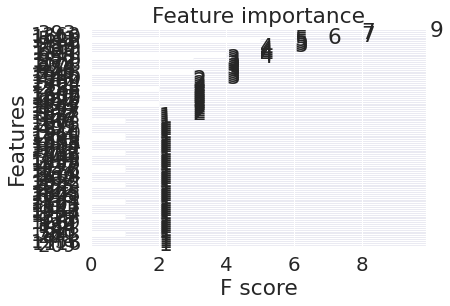

In [123]:
plt.figure(figsize=(20,12))
xgb.plot_importance(xg_reg)
plt.show()

In [124]:
model = xgb.XGBRegressor()
objective = "reg:linear"
seed = 100
n_estimators = 100
learning_rate = 0.1
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 1
silent = False

parameters = {}
parameters['objective'] = objective
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
parameters['silent'] = silent

scores = []

cv_params = {'max_depth': [2,4,6,8],
             'min_child_weight': [1,3,5,7]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                    
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)
gbm.fit(x_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

KeyboardInterrupt: ignored

In [ ]:

Bestpredict_train = best_model.predict(x_train)
Bestpredict_test = best_model.predict(x_test)

# Use score method to get accuracy of model
print("Best Model Accuracy on Training Data: {0:.4f}".format(metrics.accuracy_score(y_train, Bestpredict_train)))
print("Best Model Accuracy on Test Data: {0:.4f}".format(metrics.accuracy_score(y_test, Bestpredict_test)))

#gbm.fit(x_train,y_train)

In [ ]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_HyperParam_XGBoost = pd.DataFrame({'Classification Model':['XGBoost - HyperParameter'], 'Training Accuracy': round(metrics.accuracy_score(y_train, Bestpredict_train),2), 'Test Accuracy': round(metrics.accuracy_score(y_train, Bestpredict_test),2)},index={'4'})
Accuracy_Matrix = pd.concat([Accuracy_Matrix, Accuracy_HyperParam_XGBoost])
Accuracy_Matrix

In [ ]:
pickle_dump(gbm, "xgboostHyperParam.pickle")

In [ ]:
#SVM
from sklearn import svm

# Fit the model on train
model = svm.SVC(gamma=0.025, C=1) 
model.fit(x_train, y_train)

#predict on training data
y_predict1 = model.predict(x_train)

#predict on test data
y_predict2 = model.predict(x_test)

# Use score method to get accuracy of model
print("Model Accuracy on Training Data: {0:.4f}".format(metrics.accuracy_score(y_train, y_predict1)))
print("Model Accuracy on Test Data: {0:.4f}".format(metrics.accuracy_score(y_test, y_predict2)))
# Confusion Matrix for SVM

y_predict = model.predict(x_test)
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (10,5))
sns.set(font_scale=1.8)
ax=sns.heatmap(df_cm, annot=True)
bottom,top=ax.get_ylim()
ax.set_ylim(bottom +0.5, top-0.5)

## Vocabularizing the Deep Learning Df

In [ ]:
deep_learning_df.shape

In [ ]:
def vocabularize(text, max_features):
  x = text
  vocabSize = max_features
  tokenizer = Tokenizer(num_words=vocabSize, split=' ')
  tokenizer.fit_on_texts(x)
  x = tokenizer.texts_to_sequences(x)
  x = pad_sequences(x,MAX_LENGTH)
  return x
x = vocabularize(deep_learning_df["Description_New"], max_features)
x

In [ ]:
updated_deep_learning_df = deep_learning_df.replace(replaceStruct)
y = updated_deep_learning_df["Assignment group"]
y = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 100)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [ ]:
len(np.unique(y_train))
mapping = dict(zip([i for i in range(40)],np.unique(y_train)))
class_weights = dict(zip([i for i in range(40)],class_weights))
class_weights

In [ ]:
mapping

In [ ]:
reversemapping = dict(zip([mapping[i] for i in mapping], [i for i in mapping]))
reversemapping

In [ ]:
count = len(y_train)
y_train_new = []
for i in range(count):
  y_train_new.append(reversemapping[y_train[i]])

count = len(y_test)
y_test_new = []
for i in range(count):
  y_test_new.append(reversemapping[y_test[i]])

y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)

In [ ]:
y_train_final = np.zeros((y_train_new.size, y_train_new.max()+1))
y_train_final[np.arange(y_train_new.size),y_train_new] = 1
y_test_final = np.zeros((y_test_new.size, y_test_new.max()+1))
y_test_final[np.arange(y_test_new.size),y_test_new] = 1

In [ ]:
y_train_final

In [ ]:
y_train_final.shape

In [ ]:
y_test_final

In [ ]:
y_test_final.shape

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience = 5)

In [ ]:
#### Add your code here ####
VOCAB_SIZE = max_features
model = " "
fitted_model = " "
if os.path.exists(folder_path + "/" + "model_LSTM_trained.pickle"):
  model = get_pickle_data("model_LSTM_trained.pickle")
  fitted_model = get_pickle_data("model_LSTM_fitted.pickle")
else:
  model = Sequential() #creating sequential model
  model.add(Embedding(input_dim = VOCAB_SIZE, output_dim = 300, input_length = MAX_LENGTH)) #adding embedding layer
  model.add(SpatialDropout1D(0.2)) #added for robustness
  model.add(LSTM(units = 300, return_sequences = True, recurrent_dropout = 0.1)) #adding LSTM layer
  #model.add(TimeDistributed(Dense(100, activation = "relu"))) # timedistributed layer
  model.add(Flatten())
  model.add(Dense(len(np.unique(y)),activation="softmax")) #Dense layer

  #### Add your code here ####
  model.compile(optimizer= "adam", loss ="binary_crossentropy",metrics =["accuracy"])
  fitted_model = model.fit(x_train, y_train_final, batch_size = 64, epochs=5, verbose=1, validation_split=0.2, class_weight = class_weights,callbacks = [es])
  pickle_dump(fitted_model, "model_LSTM_fitted.pickle")
  pickle_dump(model_LSTM, "model_LSTM_trained.pickle")
score, acc = model.evaluate(x_test, y_test_final,verbose = 1)

In [ ]:
print("accuracy", acc)

In [ ]:
plt.xlabel("accuracy")
plt.ylabel("val_accuracy")
plt.plot(fitted_model.history["accuracy"],fitted_model.history["val_accuracy"], ls = "-", marker = ".", markersize = "10")

In [ ]:
#### Add your code here ####
VOCAB_SIZE = max_features
model_GRU = " "
fitted_model = " "
if os.path.exists(folder_path + "/" + "model_GRU_trained.pickle"):
  model_GRU = get_pickle_data("model_GRU_trained.pickle")
  fitted_model = get_pickle_data("model_GRU_fitted.pickle")
else:
  model_GRU = Sequential() #creating sequential model
  model_GRU.add(Embedding(input_dim = VOCAB_SIZE, output_dim = 300, input_length = MAX_LENGTH)) #adding embedding layer
  model_GRU.add(SpatialDropout1D(0.2)) #added for robustness
  model_GRU.add(GRU(units=MAX_LENGTH, return_sequences=True, input_shape=(MAX_LENGTH,1), activation='tanh'))
  #model_GRU.add(TimeDistributed(Dense(100, activation = "relu"))) # timedistributed layer
  model_GRU.add(Flatten())
  model_GRU.add(Dense(len(np.unique(y)),activation="softmax")) #Dense layer

  #### Add your code here ####
  model_GRU.compile(optimizer= "adam", loss ="binary_crossentropy",metrics =["accuracy"])
  fitted_model = model_GRU.fit(x_train, y_train_final, batch_size = 64, epochs=5, verbose=1, validation_split=0.2, class_weight = class_weights,callbacks = [es])
  pickle_dump(fitted_model, "model_GRU_fitted.pickle")
  pickle_dump(model_GRU, "model_GRU_trained.pickle")
score, acc = model_GRU.evaluate(x_test, y_test_final,verbose = 1)

In [ ]:
print("accuracy", acc)

In [ ]:
plt.xlabel("accuracy")
plt.ylabel("val_accuracy")
plt.plot(fitted_model.history["accuracy"],fitted_model.history["val_accuracy"], ls = "-", marker = ".", markersize = "10")

In [ ]:
#### Add your code here ####
VOCAB_SIZE = max_features
fitted_model = " "
model_bi_LSTM = " "
if os.path.exists(folder_path + "/" + "model_bi_LSTM_trained.pickle"):
  model_bi_LSTM = get_pickle_data("model_bi_LSTM_trained.pickle")
  fitted_model = get_pickle_data("model_bi_LSTM_fitted.pickle")
else:
  model_bi_LSTM = Sequential() #creating sequential model
  model_bi_LSTM.add(Embedding(input_dim = VOCAB_SIZE, output_dim = 300, input_length = MAX_LENGTH)) #adding embedding layer
  model_bi_LSTM.add(SpatialDropout1D(0.3)) #added for robustness
  model_bi_LSTM.add(Bidirectional(LSTM(units = 300, return_sequences = True, recurrent_dropout = 0.1))) #adding LSTM layer
  #model.add(TimeDistributed(Dense(100, activation = "relu"))) # timedistributed layer
  model_bi_LSTM.add(Flatten())
  model_bi_LSTM.add(Dense(len(np.unique(y)),activation="softmax")) #Dense layer
#### Add your code here ####
  model_bi_LSTM.compile(optimizer= "adam", loss ="binary_crossentropy",metrics =["accuracy"])
  fitted_model = model_bi_LSTM.fit(x_train, y_train_final, batch_size = 64, epochs=5, verbose=1, validation_split=0.2, class_weight = class_weights,callbacks = [es])
  pickle_dump(fitted_model, "model_bi_LSTM_fitted.pickle")
  pickle_dump(model_bi_LSTM, "model_bi_LSTM_trained.pickle")
score, acc = model_bi_LSTM.evaluate(x_test, y_test_final,verbose = 1)

In [ ]:
print("accuracy", acc)

In [ ]:
plt.xlabel("accuracy")
plt.ylabel("val_accuracy")
plt.plot(fitted_model.history["accuracy"],fitted_model.history["val_accuracy"], ls = "-", marker = ".", markersize = "10")